Use decision trees to prepare a model on fraud data 
treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

Data Description :

Undergrad : person is under graduated or not
Marital.Status : marital status of a person
Taxable.Income : Taxable income is the amount of how much tax an individual owes to the government 
Work Experience : Work experience of an individual person
Urban : Whether that person belongs to urban area or not


In [19]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split

import warnings
warnings.filterwarnings('ignore')


In [20]:
# Cell 2: Load Dataset
data_path = 'Fraud_check.csv'
fraud_data = pd.read_csv(data_path)
fraud_data.head()


,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [21]:
# Cell 3: Data Exploration
# Check for missing values and data types
print(fraud_data.isnull().sum())
print(fraud_data.info())


Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB
None


In [22]:
# Cell 4: Data Shape and Duplicates
# Display the shape of the dataset and check for duplicates
print(fraud_data.shape)
print(fraud_data[fraud_data.duplicated()].shape)


(600, 6)
(0, 6)


In [23]:
# Cell 5: Descriptive Statistics
# Get summary statistics of the dataset
fraud_data.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


In [24]:
# Cell 6: Feature Engineering
# Create a new feature 'Taxable.Category' based on 'Taxable.Income'
fraud_data['Taxable.Category'] = pd.cut(fraud_data['Taxable.Income'], bins=[10002, 30000, 99620], labels=['Risky', 'Good'])
fraud_data.head()


,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,Taxable.Category
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


In [25]:
# Cell 7: Identify Categorical and Numerical Features
# Identify categorical and numerical features in the dataset
categorical_cols = fraud_data.select_dtypes(include=['object']).columns
numerical_cols = fraud_data.select_dtypes(include=['int64']).columns
print("Categorical Features:", categorical_cols)
print("Numerical Features:", numerical_cols)


Categorical Features: Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')
Numerical Features: Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')


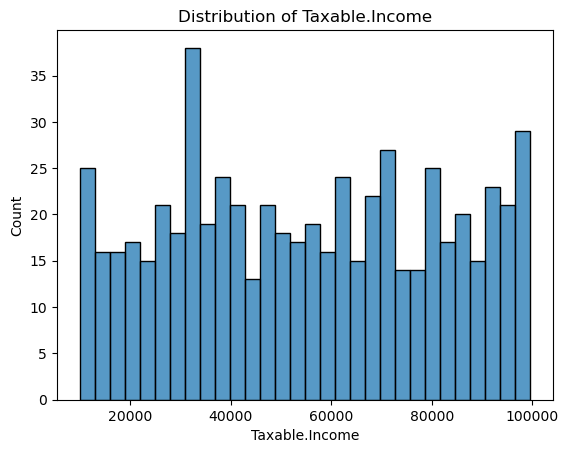

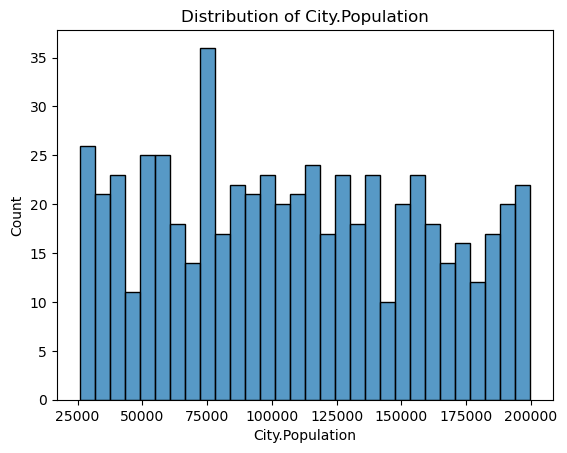

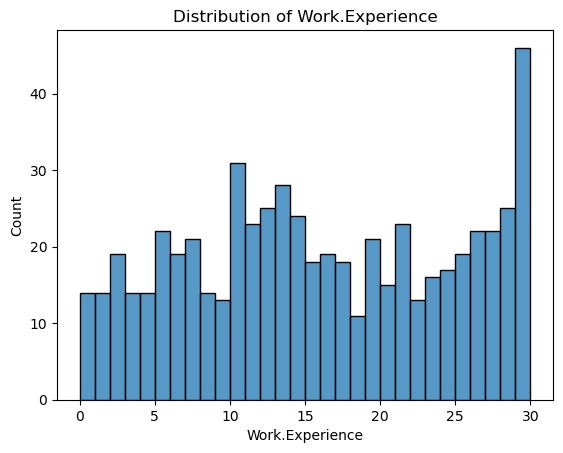

In [26]:
# Cell 8: Univariate Analysis
# Plot distribution of numerical features
for feature in numerical_cols:
  plt.figure()
  sns.histplot(fraud_data[feature], kde=False, bins=30)
  plt.title(f'Distribution of {feature}')
  plt.show()

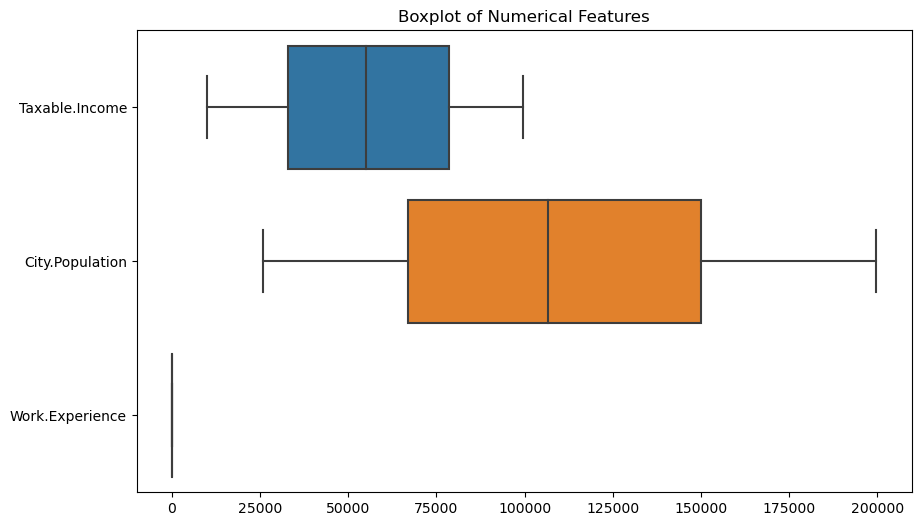

In [27]:
# Cell 9: Outlier Detection
# Visualize outliers using boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(data=fraud_data[numerical_cols], orient='h')
plt.title('Boxplot of Numerical Features')
plt.show()


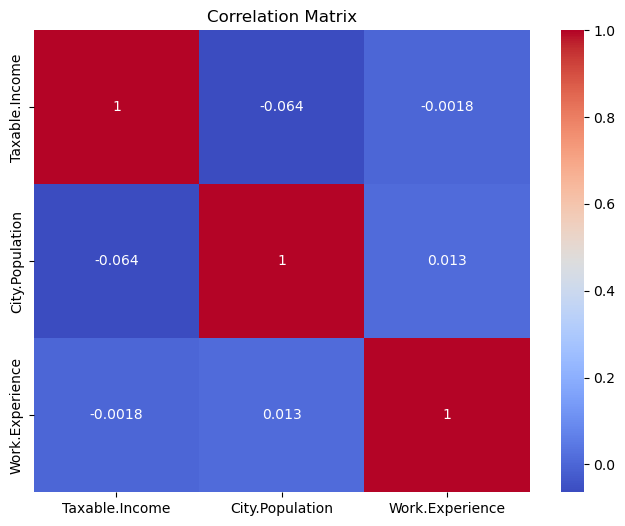

In [28]:
# Cell 10: Correlation Matrix
# Display the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(fraud_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


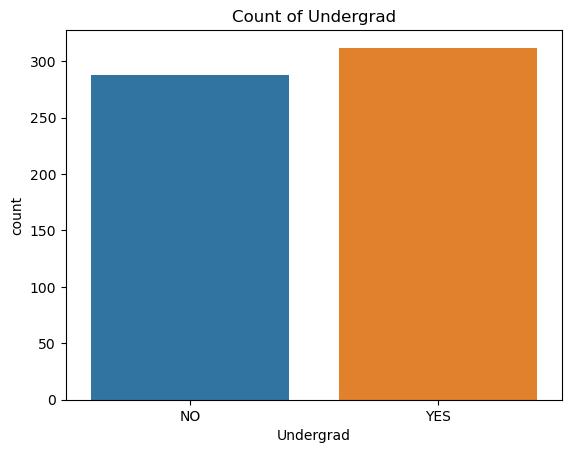

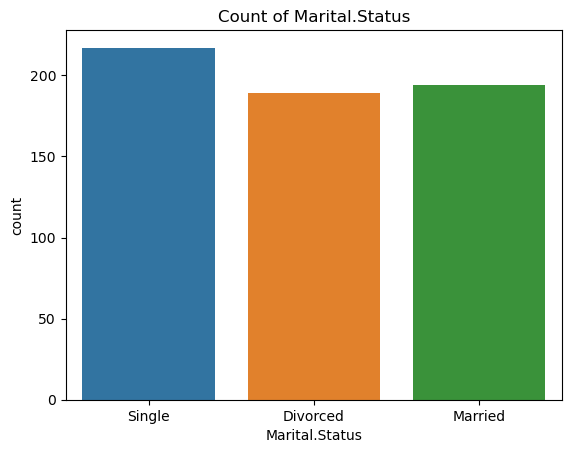

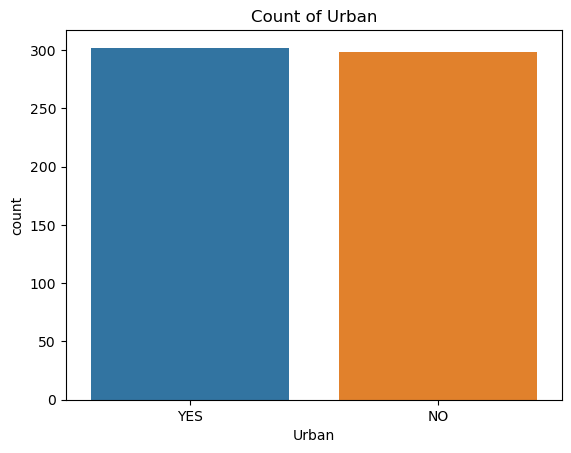

In [29]:
# Cell 11: Categorical Feature Distribution
# Plot count of each category in categorical features
for column in categorical_cols:
  plt.figure()
  sns.countplot(data=fraud_data, x=column)
  plt.title(f'Count of {column}')
  plt.show()

In [30]:
# Cell 12: Encode Categorical Features
# Encode categorical features using LabelEncoder
encoder = LabelEncoder()
for col in categorical_cols:
  fraud_data[col] = encoder.fit_transform(fraud_data[col])
fraud_data.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,Taxable.Category
0,0,2,68833,50047,10,1,Good
1,1,0,33700,134075,18,1,Good
2,0,1,36925,160205,30,1,Good
3,1,2,50190,193264,15,1,Good
4,0,1,81002,27533,28,0,Good


In [31]:
# Cell 13: Split Data into Features and Target
# Define features (X) and target (y)
X = fraud_data.drop('Taxable.Category', axis=1)
y = fraud_data['Taxable.Category']


In [32]:
# Cell 14: Train-Test Split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
# Cell 15: Model Training with GridSearchCV
# Train a Decision Tree Classifier using GridSearchCV
param_grid = {
  'criterion': ['gini', 'entropy'],
  'max_depth': [3, 4, 5, 6],
  'min_samples_split': [2, 3, 4],
  'min_samples_leaf': [1, 2, 3]
}
dt_clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4]},
             scoring='accuracy')

In [34]:
# Cell 16: Best Parameters and Model Evaluation
# Display the best parameters and evaluate the model
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.9916666666666667
Classification Report:
               precision    recall  f1-score   support

        Good       1.00      0.99      0.99        95
       Risky       0.96      1.00      0.98        25

    accuracy                           0.99       120
   macro avg       0.98      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



In [35]:
# Cell 17: Save the Model
# Save the trained model using pickle
from pickle import dump
dump(best_model, open('fraud_detection_model.pkl', 'wb'))